In [1]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from scripts.utils import get_backend_properties_v1

# from blackwater.data.utils import (
#     generate_random_pauli_sum_op,
#     create_estimator_meas_data,
#     circuit_to_graph_data_json,
#     get_backend_properties_v1,
#     encode_pauli_sum_op,
#     create_meas_data_from_estimators
# )

from scripts.mlp import MLP1, MLP2, MLP3, encode_data

#from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns
from scripts.noise_utils import AddNoise, RemoveReadoutErrors
from scripts.from_circ_to_numpy import operations_to_features
from scripts.mlp import recursive_dict_loop, count_gates_by_rotation_angle
from scripts.mbd_utils import calc_imbalance

In [2]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [3]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [4]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_coherent, noise_model = AddNoise(backend=backend).add_coherent_noise(seed=0, theta=np.pi * 0.04, uniform=False, add_depolarization=True)

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_coherent = {'shots': 10000, 'backend': backend_noisy_coherent, 'name': 'noisy_coherent'}

random seed fixed to 0
thetas [0.06896594 0.08987335 0.07574548 0.06847204 0.05323803 0.08116545
 0.05498883 0.1120635 ]


In [5]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_no_readout = RemoveReadoutErrors().remove_readout_errors()[0]

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}

# no measurement errors 
run_config_noisy_no_readout = {'shots': 10000, 'backend': backend_noisy_no_readout, 'name': 'noisy_no_readout'}

num_qubit = 4

`load_circuits` loads the quantum circuit objects from the .pk files.

In [6]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files[1:], leave=True):
        #print(data_file)
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [7]:
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals_input = load_circuits('./data/ising_init_from_qasm_no_readout/train/', '.pk')
print(len(train_circuits))

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals_input = load_circuits('./data/ising_init_from_qasm_no_readout/val/', '.pk')
print(len(test_circuits))

  0%|          | 0/14 [00:00<?, ?it/s]

4200


  0%|          | 0/14 [00:00<?, ?it/s]

1400


In [8]:
train_noisy_exp_vals = [x[0] for x in train_noisy_exp_vals_input]
test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals_input]

X_train, y_train = operations_to_features(train_circuits, train_ideal_exp_vals, n_qubits=5, backend=backend)
X_test, y_test = operations_to_features(test_circuits, test_ideal_exp_vals, n_qubits=5, backend=backend)

In [61]:
from scripts.model import *
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
import json, os


sequence_input_size = 7
sequence_hidden_size = 32
sequence_num_layers = 2
sequence_model_type = 'LSTM'
sequence_dropout = 0.05
ann_hidden_layers = 2
ann_hidden_units = 64
ann_dropout = 0
noisy_first = True

num_epochs = 3

In [62]:
y_training = []
for y in range(4):
    temp = []
    for i in range(len(y_train)):
        temp.append(y_train[i][y])
    y_training.append(temp)

y_training = torch.tensor(y_training)

In [63]:
y_testing = []
for y in range(4):
    temp = []
    for i in range(len(y_test)):
        temp.append(y_test[i][y])
    y_testing.append(temp)

y_testing = torch.tensor(y_testing)

In [64]:
train_noisy_exp_vals = torch.tensor(train_noisy_exp_vals)
test_noisy_exp_vals = torch.tensor(test_noisy_exp_vals)

C:\Users\andre\AppData\Local\Temp\ipykernel_11748\653568998.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_noisy_exp_vals = torch.tensor(train_noisy_exp_vals)
C:\Users\andre\AppData\Local\Temp\ipykernel_11748\653568998.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_noisy_exp_vals = torch.tensor(test_noisy_exp_vals)


In [65]:
model_list = []
for q in range(4):
    sequence_model, ann = create_models(sequence_input_size, 
                                        sequence_hidden_size, 
                                        sequence_num_layers, 
                                        sequence_model_type, 
                                        sequence_dropout, 
                                        ann_hidden_layers, 
                                        ann_hidden_units, 
                                        ann_dropout, 
                                        noisy_first=noisy_first)
    loss_fn = nn.MSELoss() # leave for now
    optimizer = optim.Adam(list(ann.parameters()) + list(sequence_model.parameters()), lr=0.001)  

    train_losses, test_losses = train_and_test_step(sequence_model, ann, loss_fn, optimizer, X_train, train_noisy_exp_vals[:, q], y_training[q], X_test, test_noisy_exp_vals[:, q], y_testing[q], num_epochs, noisy_first=noisy_first)

    model_list.append((sequence_model, ann))

Epoch 1/3, train loss (PyTorch): 0.1093, test_loss (scikitlearn rmse): 0.0516
Epoch 2/3, train loss (PyTorch): 0.0546, test_loss (scikitlearn rmse): 0.0508
Epoch 3/3, train loss (PyTorch): 0.0506, test_loss (scikitlearn rmse): 0.0441
Epoch 1/3, train loss (PyTorch): 0.0882, test_loss (scikitlearn rmse): 0.0453
Epoch 2/3, train loss (PyTorch): 0.0401, test_loss (scikitlearn rmse): 0.0364
Epoch 3/3, train loss (PyTorch): 0.0376, test_loss (scikitlearn rmse): 0.0328
Epoch 1/3, train loss (PyTorch): 0.1720, test_loss (scikitlearn rmse): 0.0663
Epoch 2/3, train loss (PyTorch): 0.0666, test_loss (scikitlearn rmse): 0.0540
Epoch 3/3, train loss (PyTorch): 0.0565, test_loss (scikitlearn rmse): 0.0555
Epoch 1/3, train loss (PyTorch): 0.0810, test_loss (scikitlearn rmse): 0.0544
Epoch 2/3, train loss (PyTorch): 0.0440, test_loss (scikitlearn rmse): 0.0376
Epoch 3/3, train loss (PyTorch): 0.0374, test_loss (scikitlearn rmse): 0.0360


In [66]:
y_test_tensor_proper = torch.ones(test_noisy_exp_vals.shape)
for i in range(len(y_test_tensor_proper)):
    for y in range(len(y_test_tensor_proper[0])):
        y_test_tensor_proper[i][y] = y_test[i][y]

random seed fixed to 0
RMSE_noisy_0: 0.06550247099813064
RMSE_mitigated_0: 0.044121882790603036
RMSE_noisy_1: 0.05991942535795197
RMSE_mitigated_1: 0.03277025203466923
RMSE_noisy_2: 0.1703969244030019
RMSE_mitigated_2: 0.05552452725275609
RMSE_noisy_3: 0.06290111600237397
RMSE_mitigated_3: 0.03603760935799708
RMSE_noisy: 0.101084832544792
RMSE_mitigated: 0.043018346011571354


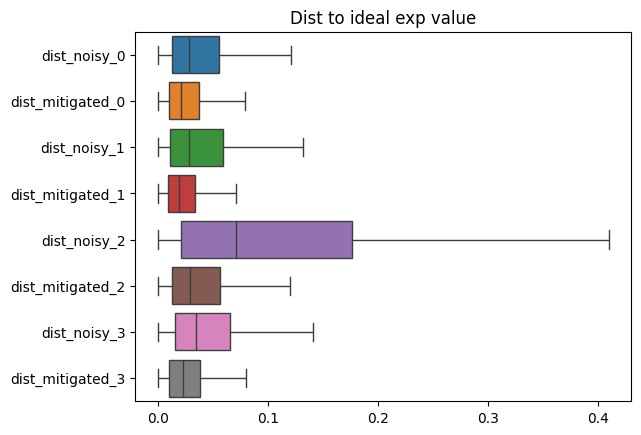

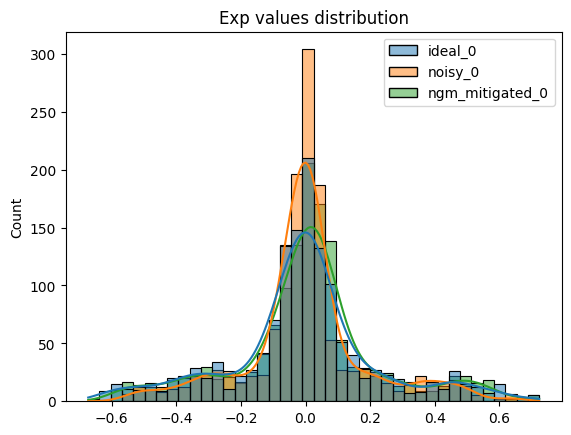

In [67]:
fix_random_seed(0)

distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

out = []
for q, model in enumerate(model_list):
    sequence_model = model[0]
    ann = model[1]
    model_output = []
    for i in range(len(X_test)):
        model_output.append(float(run_models(sequence_model, ann, X_test[i], test_noisy_exp_vals[i][q], noisy_first).detach().cpu().numpy()))
    out.append(model_output)
out = np.array(out).transpose()
# out = rfr.predict(batch_X[:, -4:])

for ideal, noisy, ngm_mitigated in zip(
    y_test_tensor_proper.tolist(),
    test_noisy_exp_vals.tolist(),
    out.tolist()
):
    imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
    imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
    imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
    for q in range(4):
        ideal_q = ideal[q]
        noisy_q = noisy[q]
        ngm_mitigated_q = ngm_mitigated[q]
        distances.append({
            f"ideal_{q}": ideal_q,
            f"noisy_{q}": noisy_q,
            f"ngm_mitigated_{q}": ngm_mitigated_q,
            f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
            f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
            f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
            f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            "imb_ideal": imbalance_ideal,
            "imb_noisy": imbalance_noisy,
            "imb_ngm": imbalance_mitigated,
            "imb_diff": imbalance_ideal - imbalance_mitigated
        })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(4):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()